In [1]:
!pip install torchsummary
import torch
import torchvision
from torchsummary import summary


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
num_classes = 10  
num_bits = 16 


In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader

mean_values = [0.485, 0.456, 0.406]
std_values = [0.229, 0.224, 0.225]

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_values, std=std_values)
        ])

CIFAR10 = torchvision.datasets.CIFAR10(root =  'Datasets', download=True, transform=transform, train=True)



Files already downloaded and verified


In [4]:
dataloader = DataLoader(CIFAR10, batch_size= 256,shuffle= True)

In [5]:
CIFAR10.__getitem__(0)[0].shape

torch.Size([3, 32, 32])

In [6]:
import torchvision.models as models
from torchvision.models import VGG16_Weights
import torch.nn as nn
# Importing VGG model

vgg = models.vgg16(weights=VGG16_Weights.DEFAULT).to(device)
vgg.classifier = nn.Sequential(*list(vgg.classifier.children())[:-1])


summary(vgg, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

In [7]:
import torch.nn as nn
class model(nn.Module):
    def __init__(self, classifier, bit_length = 32):
        super(model, self).__init__()
        self.classifier = classifier

        # self.fc1 = nn.Sequential()
        # self.fc1.add_module('fc6_s1',nn.Linear(512, 1024)) #256*3*3
        # self.fc1.add_module('relu6_s1',nn.ReLU(inplace=True))
        # self.fc1.add_module('drop6_s1',nn.Dropout(p=0.5))

        # self.fc2 = nn.Sequential()
        # self.fc2.add_module('fc2',nn.Linear(1024, 512))
        # self.fc2.add_module('relu7',nn.ReLU(inplace=True))
        # self.fc2.add_module('drop7',nn.Dropout(p=0.5))

        # self.fc3 = nn.Sequential()
        # self.fc3.add_module('fc8',nn.Linear(512, hash_length))
        # self.fc3.add_module('tanh', nn.Tanh())
        self.fc = nn.Sequential(
                nn.Dropout(0.2),
                nn.Linear(4096, 2048),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(2048, 2048),
                nn.ReLU(inplace=True),
                nn.Linear(2048, bit_length),
                nn.BatchNorm1d(bit_length),
                # nn.Tanh()
            )
    def forward(self, x):
        x = self.classifier(x)
        # x = torch.flatten(x, start_dim= 1, end_dim= 3)
        x = self.fc(x)
        # x = self.fc2(x)
        # x = self.fc3(x)
        return x


In [8]:
vgg_model = model(vgg, bit_length= num_bits)
vgg_model.to(device)

model(
  (classifier): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [9]:
image, labels = next(iter(dataloader))
image = image.to(device)
labels = labels.to(device)

# output = vgg(image)
output  = vgg_model(image)
output.max()

tensor(6.8782, device='cuda:0', grad_fn=<MaxBackward1>)

In [10]:
import torch.nn.functional as F
class MSE_loss(nn.Module):
    def __init__(self):
        super(MSE_loss, self).__init__()

    def forward(self, U,labels):
        L = F.one_hot(labels).to(torch.float64)
        S = torch.matmul(L, L.T)

        theta= 1/2 * torch.matmul(U, U.T)
        loss = torch.sum((S - theta) ** 2)
        return loss

In [11]:
import torch.nn.functional as F
import numpy as np

def generate_orthogonal_targets(num_classes, num_bits):
  # Generate a random matrix of shape (num_classes, num_bits)
	# We'll use a slight modification to ensure it's correct:
	# if num_bits < num_classes, QR might not work as expected because QR returns min(num_classes, num_bits) columns.
	# We need to ensure the matrix is at least square or that num_bits >= num_classes.
    targets = np.random.randn(max(num_classes, num_bits), num_bits)
    q, _ = np.linalg.qr(targets)
	# Make sure to select only the first num_classes rows after QR decomposition if num_bits < num_classes.
    q = q[:num_classes]
    binary_targets = np.sign(q)
    return torch.tensor(binary_targets, dtype=torch.float32, device=device)

class OrthoHashLoss(torch.nn.Module):
    def __init__(self, num_classes, num_bits, n_cos = 1 , n_mse = 1 ):
        super(OrthoHashLoss, self).__init__()
        # Initialize binary orthogonal targets and send them to the specified device
        self.n_cos = n_cos
        self.n_mse = n_mse
        self.O = generate_orthogonal_targets(num_classes, num_bits).to(device)
    def mse_loss(self, v, labels):
        return F.mse_loss(v, self.O[labels])
    def cosine_loss(self, v, labels):
        v_norm = F.normalize(v, p=2, dim=1).to(device)
        # Compute the logits by dot product of normalized codes and orthogonal targets
        logits = torch.mm(v_norm, self.O.t())
        # Cross-entropy loss between predicted logits and actual class labels
        return F.cross_entropy(logits, labels)

    def forward(self, v, labels):

        return self.n_cos * self.cosine_loss(v, labels) + self.n_mse * self.mse_loss(v, labels)

# Example usage
num_classes = 10  # Number of classes
num_bits = 32	# Dimension of the binary hash codes
loss_func = OrthoHashLoss(num_classes, num_bits)
v = torch.randn(64, num_bits).to(device)  # Example batch of continuous codes
labels = torch.randint(0, num_classes, (64,)).to(device)  # Example batch of labels
loss = loss_func(v, labels)
print("Loss:", loss.item())


Loss: 4.507844924926758


In [12]:
O = generate_orthogonal_targets(num_classes= num_classes, num_bits=num_bits)

In [24]:
import torch
import torch.optim as optim
from tqdm import tqdm

# Assuming 'vgg_model' is already defined and loaded properly
num_classes = 10  # Set the number of classes according to your model's output
num_bits = 16    # Set the dimension of the hash codes

for param in vgg_model.classifier.parameters():
        param.requires_grad = False

# Assuming the last fully connected layer is named 'fc' and you want to train it
optimizer = optim.Adam(vgg_model.fc.parameters(), lr=0.001)
eta = 0.1
epochs = 70

# Initialize the custom loss function
loss_fn = OrthoHashLoss(num_classes, num_bits, n_cos=1, n_mse=0)
# loss_fn = MSE_loss()

# loss_list = []

for epoch in range(epochs):
    loop = tqdm(dataloader)
    total_loss = 0
    reg_loss = 0

    for data in loop:
        images, labels = data

        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        # forward
        U = vgg_model(images)

        # Calculate regularization term
        reg = torch.sum((torch.sgn(U) - U)**2)

        # Calculate loss
        loss = loss_fn(U, labels) 
        total_loss += loss.item()

        # backward + optimize
        loss.backward()
        optimizer.step()

        loop.set_postfix(epoch=epoch, loss=loss.item())

    # Compute average losses for logging
    avg_total_loss = total_loss / len(loop)

    loss_list.append(avg_total_loss)

    # Optionally log the progress at certain intervals
    print(f'Epoch [{epoch+1}/{epochs}], Avg Loss: {avg_total_loss:.4f}')

print('Finished Training')


100%|██████████| 196/196 [00:20<00:00,  9.76it/s, epoch=0, loss=0.481]


Epoch [1/70], Avg Loss: 0.6745


100%|██████████| 196/196 [00:21<00:00,  9.29it/s, epoch=1, loss=0.246]


Epoch [2/70], Avg Loss: 0.2768


100%|██████████| 196/196 [00:22<00:00,  8.77it/s, epoch=2, loss=0.255]


Epoch [3/70], Avg Loss: 0.2267


100%|██████████| 196/196 [00:22<00:00,  8.60it/s, epoch=3, loss=0.244]


Epoch [4/70], Avg Loss: 0.2089


 29%|██▉       | 57/196 [00:06<00:15,  8.83it/s, epoch=4, loss=0.205]

In [15]:
torch.save(vgg_model.state_dict(), 'Saved_models/vgg16_ortho_mse_BN.pth')

In [37]:
U.max()

tensor(651.7277, device='cuda:0', grad_fn=<MaxBackward1>)

In [28]:
param_count = 0
for param in vgg_model.classifier.parameters():
    param_count += len(param)

param_count

24832

In [29]:
param_count = 0
for param in vgg_model.fc.parameters():
    param_count += len(param)

param_count

8224

In [ ]:
#loading
loaded_state_dict = torch.load('vgg16.pth')

# Load state dictionary into model
vgg_model.load_state_dict(loaded_state_dict)

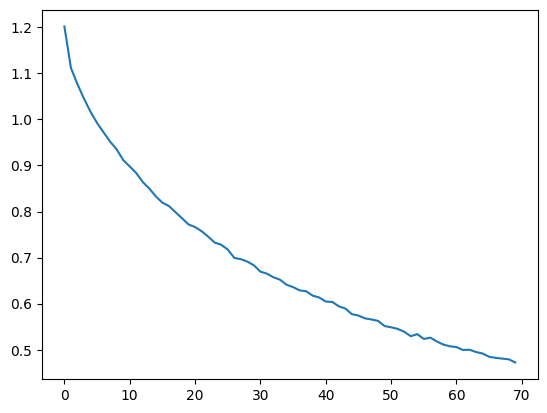

In [16]:
import matplotlib.pyplot as plt

epoch = range(0,len(loss_list))
plt.plot(epoch, loss_list)
plt.show()

In [ ]:
# epoch = range(0,40)
# plt.plot(epoch, mse_loss_list)
# plt.show()

In [17]:
import numpy as np

def CalcHammingDist(B1, B2):
    q = B2.shape[1]
    distH = 0.5 * (q - np.dot(B1, B2.transpose()))
    return distH

def CalcMap(qB, rB, queryL, retrievalL):
    num_query = queryL.shape[0]
    map = 0
    for iter in range(num_query):
        gnd = (np.dot(queryL[iter, :], retrievalL.transpose()) > 0).astype(np.int64)
        tsum = np.sum(gnd)
        if tsum == 0:
            continue
        hamm = CalcHammingDist(qB[iter, :], rB)
        ind = np.argsort(hamm)
        gnd = gnd[ind]
        count = np.linspace(1, tsum, tsum)
        tindex = np.asarray(np.where(gnd == 1)) + 1.0
        map_ = np.mean(count / (tindex))
        map = map + map_
    map = map / num_query
    return map

def CalcTopMap(qB, rB, queryL, retrievalL, topk):
    num_query = queryL.shape[0]
    topkmap = 0
    for iter in range(num_query):
        gnd = (np.dot(queryL[iter, :], retrievalL.transpose()) > 0).astype(np.int64)
        hamm = CalcHammingDist(qB[iter, :], rB)
        ind = np.argsort(hamm)
        gnd = gnd[ind]
        tgnd = gnd[0:topk]
        tsum = np.sum(tgnd)
        if tsum == 0:
            continue
        count = np.linspace(1, tsum, tsum)
        tindex = np.asarray(np.where(tgnd == 1)) + 1.0
        topkmap_ = np.mean(count / (tindex))
        topkmap = topkmap + topkmap_
    topkmap = topkmap / num_query
    return topkmap


In [18]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_values, std=std_values)
        ])

CIFAR10_test = torchvision.datasets.CIFAR10(root =  'Datasets', download=True, transform=transform, train = False)

testloader = DataLoader(CIFAR10_test, batch_size= 256,shuffle= True)

Files already downloaded and verified


In [19]:
list = []
labels_list = []
for images, labels in testloader:

    images = images.to(device)
    labels = labels.to(device)

    vgg_model.eval()
    U  = vgg_model(images)
    B = torch.sgn(U)
    B  = B.detach().cpu().numpy().astype(np.int64)
    list.append(B)

    labels = F.one_hot(labels).detach().cpu().numpy()
    labels_list.append(labels)

qB = np.concatenate(list, axis = 0)
test_labels = np.concatenate(labels_list, axis = 0)

list = []
labels_list = []
for images, labels in dataloader:

    images = images.to(device)
    labels = labels.to(device)

    vgg_model.eval()
    U  = vgg_model(images)
    B = torch.sgn(U)
    B  = B.detach().cpu().numpy().astype(np.int64)
    list.append(B)

    labels = F.one_hot(labels).detach().cpu().numpy()
    labels_list.append(labels)

rB = np.concatenate(list, axis = 0)
train_labels = np.concatenate(labels_list)

In [22]:
CalcMap(qB, rB, test_labels, train_labels)

0.6780217915392015

In [23]:
topk = 200
CalcTopMap(qB, rB, test_labels, train_labels, topk)

0.6353504707978971